In [4]:
import numpy as np
import torch
from torch import nn
from torchinfo import summary
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from funciones import train_model, visualize_true_vs_pred_regression, plot_history, grafico_pasos
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [5]:
data= np.load('Datos/Transformados/montecarlo_data.npz')
features = data['features']
target = data['target']

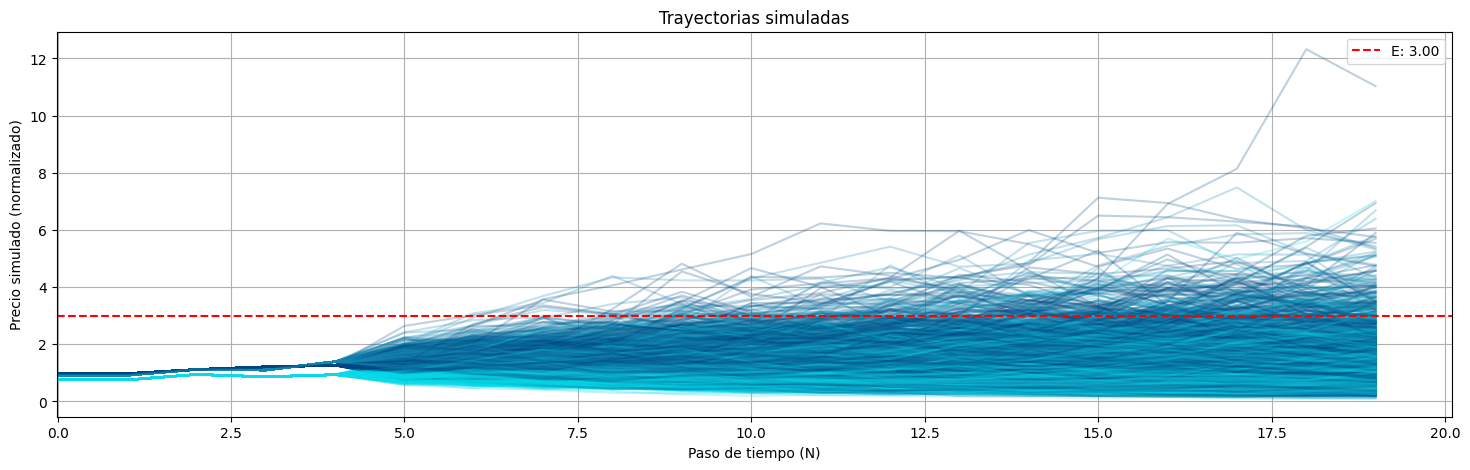

In [6]:
bbva_palette = ['#004481',
                '#1586AF',
                '#08DAE9']
plt.figure(figsize=(18, 5))
for i in range(1000):
    for j in range(features.shape[2]): # plotea 20 trayectorias aleatorias del activo 1
        plt.plot(features[i, :, j], alpha=0.25, color = bbva_palette[j])
plt.axhline(y=3, color='red', linestyle='--', label = f'E: {3:.2f}')
plt.title("Trayectorias simuladas")
plt.xlabel("Paso de tiempo (N)")
plt.ylabel("Precio simulado (normalizado)")
plt.xlim(-0.01,20.1)
plt.legend()
plt.grid(True)
plt.show()



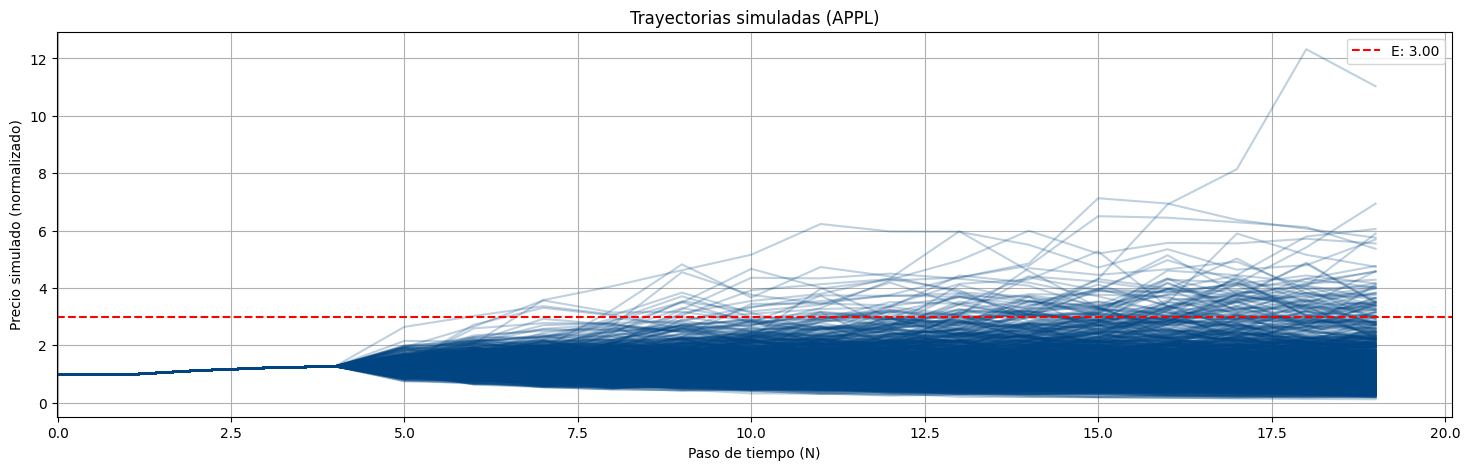

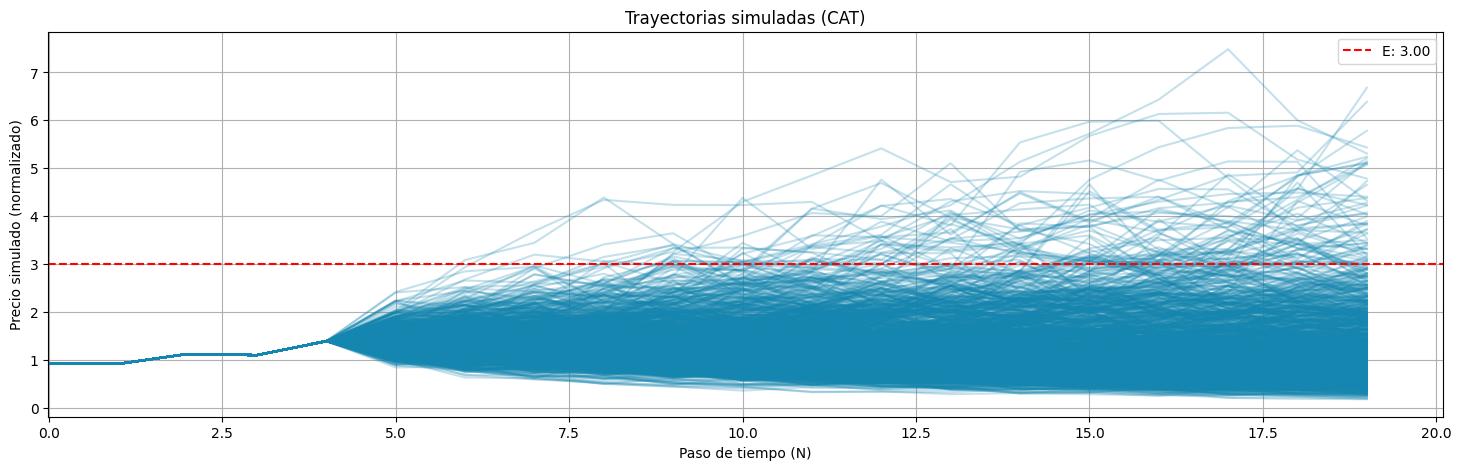

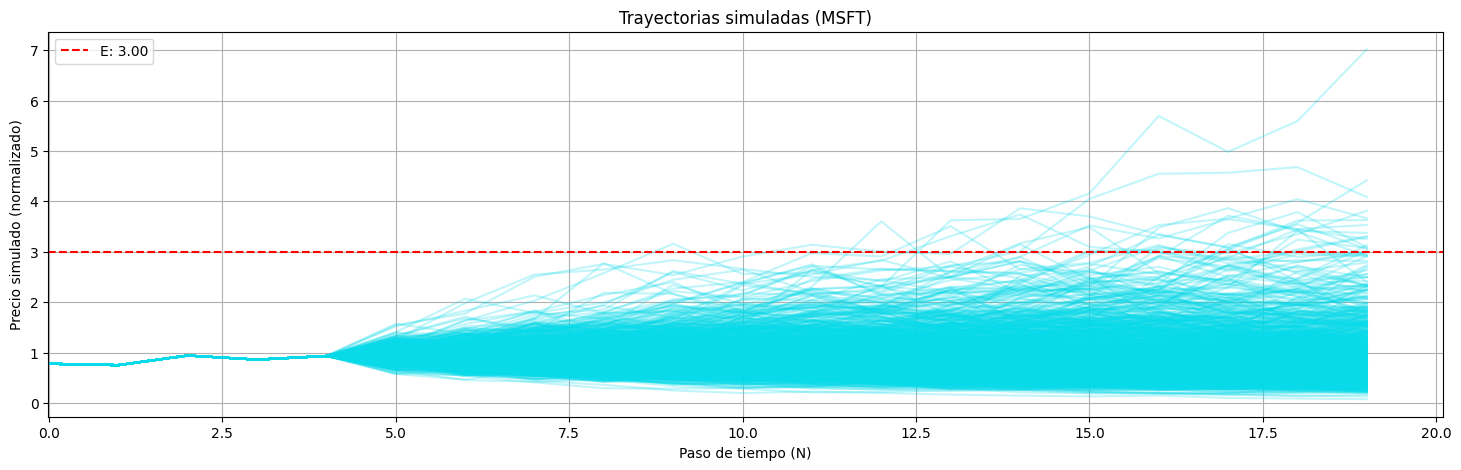

In [7]:
plt.figure(figsize=(18, 5))
for i in range(1000):
    plt.plot(features[i, :, 0], alpha=0.25, color = bbva_palette[0])
plt.axhline(y=3, color='red', linestyle='--', label = f'E: {3:.2f}')
plt.title("Trayectorias simuladas (APPL)")
plt.xlabel("Paso de tiempo (N)")
plt.ylabel("Precio simulado (normalizado)")
plt.xlim(-0.01,20.1)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(18, 5))
for i in range(1000):
    plt.plot(features[i, :, 1], alpha=0.25, color = bbva_palette[1])
plt.axhline(y=3, color='red', linestyle='--', label = f'E: {3:.2f}')
plt.title("Trayectorias simuladas (CAT)")
plt.xlabel("Paso de tiempo (N)")
plt.ylabel("Precio simulado (normalizado)")
plt.xlim(-0.01,20.1)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(18, 5))
for i in range(1000):
    plt.plot(features[i, :, 2], alpha=0.25, color = bbva_palette[2])
plt.axhline(y=3, color='red', linestyle='--', label = f'E: {3:.2f}')
plt.title("Trayectorias simuladas (MSFT)")
plt.xlabel("Paso de tiempo (N)")
plt.ylabel("Precio simulado (normalizado)")
plt.xlim(-0.01,20.1)
plt.legend()
plt.grid(True)
plt.show()

### CREACIÓN DE LOADERS

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(
    features, 
    target, 
    test_size=0.4, 
    random_state=42,
    shuffle=True 
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, 
    y_temp, 
    test_size=0.5, 
    random_state=42,
    shuffle=True  
)

print(f"Features de Train:  {X_train.shape}")   
print(f"Targets de Train:   {y_train.shape}")
print(f"Features de validation:  {X_val.shape}") 
print(f"Targets de validation:   {y_val.shape}")
print(f"Features de test:  {X_test.shape}") 
print(f"Targets de test:   {y_test.shape}")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float), torch.tensor(y_val, dtype=torch.float))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.float))


batch_size = 64 
train_dataloader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True) 


val_dataloader = DataLoader(dataset=val_dataset, 
                          batch_size=batch_size, 
                          shuffle=False) 

test_dataloader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False) 


Features de Train:  (60000, 20, 3)
Targets de Train:   (60000,)
Features de validation:  (20000, 20, 3)
Targets de validation:   (20000,)
Features de test:  (20000, 20, 3)
Targets de test:   (20000,)


### CREACIÓN DE CLASES: MODELO Y EARLY STOPPER

In [ ]:
import torch
import torch.nn as nn

class GRUmodel(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, num_layers=2, dropout=0.4):
        super(GRUmodel, self).__init__()
        # Capa GRU
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        # Capa fully connected para salida escalar
        self.fc = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()  # Para asegurar salida >= 0

    def forward(self, x):
        """
        x: tensor de forma (batch_size, pasos_temporales, input_dim)
        """
        out, _ = self.gru(x)        
        out = out[:, -1, :]         
        out = self.fc(out)     
        out = self.relu(out)
        return out


In [5]:
import torch
import torch.nn as nn

class LSTMmodel(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, num_layers=2, dropout=0.3):
        super(LSTMmodel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()              

    def forward(self, x):
        """
        x: tensor de forma (batch_size, pasos_temporales, input_dim)
        """
        out, _ = self.lstm(x)           
        out = out[:, -1, :]             
        out = self.fc(out)              
        out = self.relu(out)  
        return out


In [10]:
class EarlyStopper: 
    def __init__(self, patience=1, min_delta=0,save_path = "./best_model.pt"):
        self.patience = patience
        self.min_delta = min_delta
        self.save_path = save_path
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss,model):
        """Returns whether the training should stop or not. If stopping criterion is not met returns False."""
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

### ENTRENAMIENTO DEL MODELO

In [ ]:
# Hiperparametros del mejor modelo
dropout = 0.4
hidden_size = 64
lr = 0.001
num_layers = 2
gamma= 0.95
clip_value=1
epochs=50
patience=5
min_delta=0
path = './mejor_modelo.pt'

In [ ]:
model = LSTMmodel(input_dim = 3, hidden_dim= hidden_size, num_layers=num_layers, dropout=dropout)
model_empty =  LSTMmodel(input_dim = 3, hidden_dim= hidden_size, num_layers=num_layers, dropout=dropout)
early_stopper = EarlyStopper(patience=patience, min_delta=min_delta, save_path=path)
print(summary(model))

Layer (type:depth-idx)                   Param #
LSTMmodel                                --
├─LSTM: 1-1                              50,944
├─Linear: 1-2                            65
├─ReLU: 1-3                              --
Total params: 51,009
Trainable params: 51,009
Non-trainable params: 0


In [9]:
history = train_model(model, 
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            test_dataloader=test_dataloader,
            criterion=nn.MSELoss(), 
            lr=lr,
            optimizer = optim.Adam, 
            epochs=epochs,
            early_stopper=early_stopper, 
            clip_value=clip_value,
            gamma= gamma,
            model_empty=model_empty,
            path=path
            )

Epoch 1 | Train Loss: 0.00081817 | Validation Loss: 0.00015531
Epoch 2 | Train Loss: 0.00015858 | Validation Loss: 0.00003015
Epoch 3 | Train Loss: 0.00010135 | Validation Loss: 0.00002527
Epoch 4 | Train Loss: 0.00009137 | Validation Loss: 0.00002719
Epoch 5 | Train Loss: 0.00007406 | Validation Loss: 0.00003326
Epoch 6 | Train Loss: 0.00006795 | Validation Loss: 0.00001697
Epoch 7 | Train Loss: 0.00006186 | Validation Loss: 0.00003848
Epoch 8 | Train Loss: 0.00005499 | Validation Loss: 0.00007180
Epoch 9 | Train Loss: 0.00005441 | Validation Loss: 0.00002071
Epoch 10 | Train Loss: 0.00005329 | Validation Loss: 0.00001482
Epoch 11 | Train Loss: 0.00004912 | Validation Loss: 0.00004232
Epoch 12 | Train Loss: 0.00004490 | Validation Loss: 0.00000684
Epoch 13 | Train Loss: 0.00004521 | Validation Loss: 0.00002037
Epoch 14 | Train Loss: 0.00004184 | Validation Loss: 0.00000808
Epoch 15 | Train Loss: 0.00003837 | Validation Loss: 0.00001060
Epoch 16 | Train Loss: 0.00003803 | Validation Lo

In [13]:
history


{'loss': [0.0008181744979384044,
  0.00015857980275371422,
  0.00010134637682349422,
  9.136993014835753e-05,
  7.405529799095045e-05,
  6.795143845568722e-05,
  6.185813364960874e-05,
  5.4988936350370445e-05,
  5.440755426437439e-05,
  5.328579313257554e-05,
  4.9117074566311205e-05,
  4.490273210491675e-05,
  4.521249954220063e-05,
  4.183524293621303e-05,
  3.837359188085732e-05,
  3.803248450373455e-05,
  3.68703888215047e-05],
 'val_loss': [0.00015531037212349475,
  3.0149035720387472e-05,
  2.527010455087293e-05,
  2.719348398677539e-05,
  3.326358554477338e-05,
  1.696552799839992e-05,
  3.848319771932438e-05,
  7.180143545847386e-05,
  2.0712320989696307e-05,
  1.4816071922541595e-05,
  4.231754347565584e-05,
  6.837189923680853e-06,
  2.0369469083379955e-05,
  8.084506646264345e-06,
  1.0602279503655155e-05,
  1.4730675128521398e-05,
  8.256561584130395e-06],
 'epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 'test_loss': 6.892835667531472e-06}

In [22]:
history2 = {'epoch': history['epoch'][2:], 'loss': history['loss'][2:], 'val_loss': history['val_loss'][2:]}

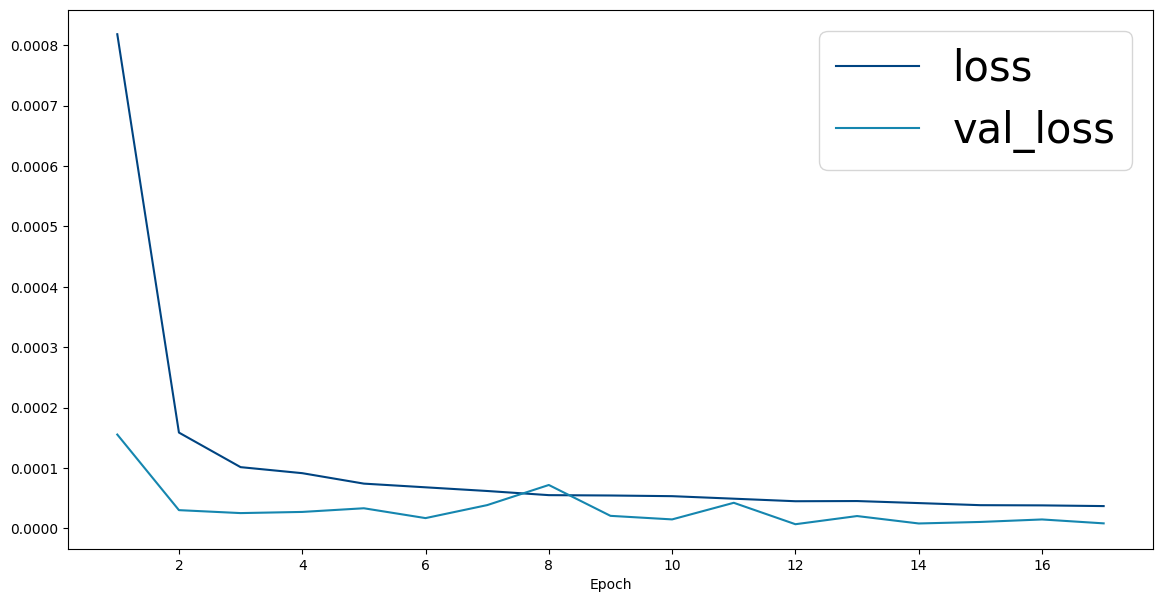

In [24]:
plot_history(history, ['loss', 'val_loss'], palette=bbva_palette)

In [25]:
model = LSTMmodel(input_dim = 3, hidden_dim= hidden_size, num_layers=num_layers, dropout=dropout)
model.load_state_dict(torch.load(path))


<All keys matched successfully>

In [26]:
model.eval()
with torch.no_grad():
        X_test_t = torch.tensor(X_test, dtype=torch.float)
       
        t_preds = model(X_test_t).cpu().detach().numpy().squeeze()
       
        
        MAE = mean_absolute_error(y_test, t_preds)
        MSE = mean_squared_error(y_test, t_preds)
        r2 = r2_score(y_test, t_preds)
            

print(f'{MAE:.8f}')
print(f'{MSE:.8f}')
print(f'{r2:.8f}')
            

0.00158099
0.00000689
0.99977392


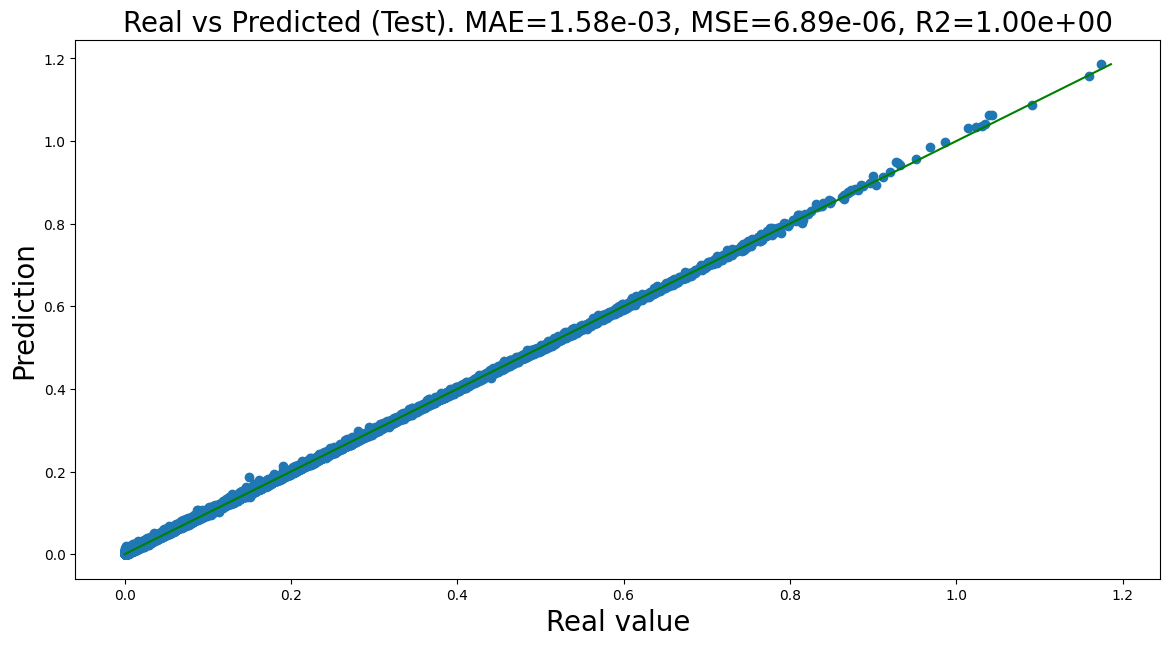

In [27]:
visualize_true_vs_pred_regression(y_test, t_preds)

In [ ]:
model.eval()
rf = 0.01
media_payoffs = model(torch.tensor(features, dtype=torch.float32)).detach().numpy().mean()
media_payoffs

0.13984357

In [ ]:
actualizacion = np.exp(-(rf)*5)
prima = actualizacion * media_payoffs
print(f'Media de Payoffs: {media_payoffs}')
print(f'Prima actualizada al valor presente: {prima}')

Media de Payoffs: 0.13984356820583344
Prima actualizada al valor presente: 0.1330233169045613


In [14]:
mses = []
criterion = nn.MSELoss()
pasos_totales = X_test.shape[1] 

y_test_tensor = torch.tensor(y_test, dtype=torch.float).squeeze()

for i in range(pasos_totales, 0, -1):
    datos = X_test[:, -i:, :]
    model.eval()

    with torch.no_grad():
        test = torch.tensor(datos, dtype=torch.float)
        pred = model(test)
        pred = pred.squeeze() 
        
    mse_loss = criterion(pred, y_test_tensor)
    mses.append(mse_loss.item())


pasos = list(range(pasos_totales, 0, -1))


In [16]:
mses

[2.6796382371685468e-05,
 0.00010519082570681348,
 0.00027440101257525384,
 0.0003362011630088091,
 0.0003949898818973452,
 0.0003122731577605009,
 0.00023928725568111986,
 0.00023880333174020052,
 0.000380522949853912,
 0.0007359107839874923,
 0.0013722238363698125,
 0.002373999450355768,
 0.0037982631474733353,
 0.005664939526468515,
 0.007983646355569363,
 0.010741647332906723,
 0.013940655626356602,
 0.017653247341513634,
 0.022066742181777954,
 0.02711845003068447]

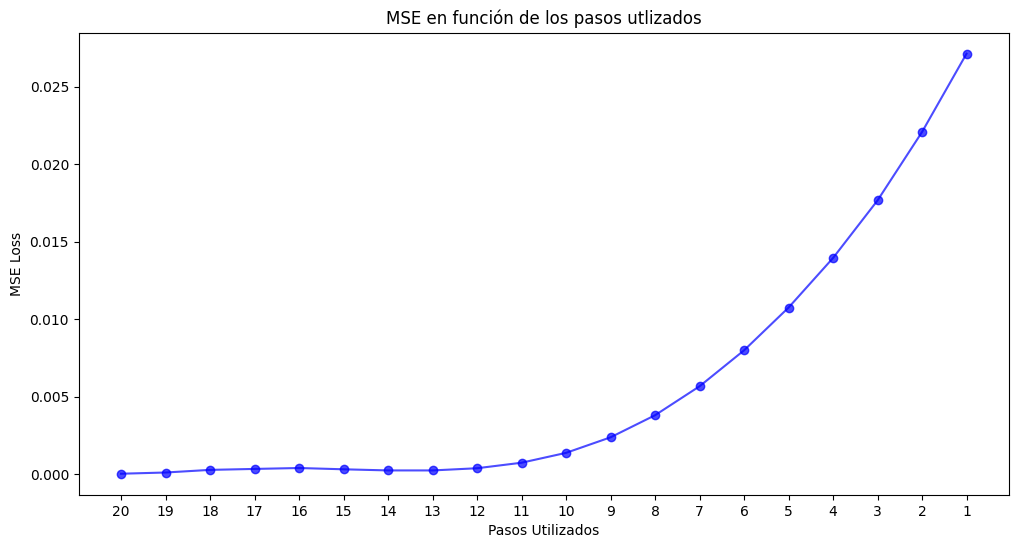

In [ ]:
grafico_pasos(pasos, mses)

Este gráfico demuestra cómo el MSE en la predicción de payoffs permanece estable y muy bajo al usar entre 20 y 13 pasos de simulación, pero se dispara exponencialmente al usar menos de 11, sirviendo para encontrar el equilibrio óptimo entre velocidad de cómputo y precisión del modelo.

In [11]:
dropout = 0.2
hidden_size = 64
lr = 0.001
num_layers = 2
gamma= 0.95
clip_value=1
epochs=50
patience=5
min_delta=0
path = './modelo_GRU.pt'
model = GRUmodel(input_dim = 3, hidden_dim= hidden_size, num_layers=num_layers, dropout=dropout)
model_empty =  GRUmodel(input_dim = 3, hidden_dim= hidden_size, num_layers=num_layers, dropout=dropout)
early_stopper = EarlyStopper(patience=patience, min_delta=min_delta, save_path=path)
print(summary(model))

Layer (type:depth-idx)                   Param #
GRUmodel                                 --
├─GRU: 1-1                               38,208
├─Linear: 1-2                            65
├─ReLU: 1-3                              --
Total params: 38,273
Trainable params: 38,273
Non-trainable params: 0


In [12]:
history_gru = train_model(model, 
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            test_dataloader=test_dataloader,
            criterion=nn.MSELoss(), 
            lr=lr,
            optimizer = optim.Adam, 
            epochs=epochs,
            early_stopper=early_stopper, 
            clip_value=clip_value,
            gamma= gamma,
            model_empty=model_empty,
            path=path
            )

Epoch 1 | Train Loss: 0.00099538 | Validation Loss: 0.00007187
Epoch 2 | Train Loss: 0.00011228 | Validation Loss: 0.00013116
Epoch 3 | Train Loss: 0.00008545 | Validation Loss: 0.00022478
Epoch 4 | Train Loss: 0.00006302 | Validation Loss: 0.00005628
Epoch 5 | Train Loss: 0.00005890 | Validation Loss: 0.00001225
Epoch 6 | Train Loss: 0.00004756 | Validation Loss: 0.00001737
Epoch 7 | Train Loss: 0.00004098 | Validation Loss: 0.00002935
Epoch 8 | Train Loss: 0.00004176 | Validation Loss: 0.00001584
Epoch 9 | Train Loss: 0.00003358 | Validation Loss: 0.00000677
Epoch 10 | Train Loss: 0.00003219 | Validation Loss: 0.00002480
Epoch 11 | Train Loss: 0.00002997 | Validation Loss: 0.00002272
Epoch 12 | Train Loss: 0.00002932 | Validation Loss: 0.00001263
Epoch 13 | Train Loss: 0.00002551 | Validation Loss: 0.00000776
Early stop en epoch 14
Test Loss: 5.995260731287999e-06


In [18]:
model.eval()
with torch.no_grad():
        X_test_t = torch.tensor(X_test, dtype=torch.float)
       
        t_preds = model(X_test_t).cpu().detach().numpy().squeeze()
       
        
        MAE = mean_absolute_error(y_test, t_preds)
        MSE = mean_squared_error(y_test, t_preds)
        r2 = r2_score(y_test, t_preds)
            

print(f'{MAE:.8f}')
print(f'{MSE:.8f}')
print(f'{r2:.8f}')

0.00197002
0.00001937
0.99936465


In [ ]:
model = GRUmodel(input_dim = 3, hidden_dim= hidden_size, num_layers=num_layers, dropout=dropout)
model.load_state_dict(torch.load(path))

In [ ]:
model.eval()
rf = 0.01
media_payoffs = model(torch.tensor(features, dtype=torch.float32)).detach().numpy().mean()
media_payoffs

actualizacion = np.exp(-(rf)*5)
prima = actualizacion * media_payoffs
print(f'Media de Payoffs: {media_payoffs}')
print(f'Prima actualizada al valor presente: {prima}')


In [ ]:
visualize_true_vs_pred_regression(y_test, t_preds)